## Data Characteristics & Challenge
**Type:** The dataset is **Tabular Data** representing clinical records.
**Challenge:** High missingness (~90% in some features).
**Solution:** We filtered columns with >90% missing values and rows with no data. For remaining missing values, we used **Median Imputation** because clinical variables (like CRP) often have skewed distributions (outliers), making the mean unreliable.

### The Challenge: High Missingness
The clinical dataset is extremely sparse (90%+ missing values in some features). Dropping rows would discard most patients and erase meaningful clinical signal. Therefore, we keep the data and apply **imputation** (median imputation in this notebook) after filtering to make the dataset usable without biasing toward complete cases.

The visualization below shows the percentage of missing values per feature **before** any filtering or imputation.

### Data Normalization
We applied `StandardScaler` (Z-score normalization) to transform all features to a mean of 0 and standard deviation of 1. This is **critical** because downstream algorithms like PCA and Hierarchical Clustering are distance-based (Euclidean distance) and sensitive to scale differences.

The histograms below show that clinical variables are highly skewed and non-normal. This observation justifies our later choice of **Non-Parametric Statistical Tests** (Kruskal-Wallis) instead of standard ANOVA.

StandardScaler is used because distance-based algorithms (PCA, clustering) are sensitive to differing feature scales.

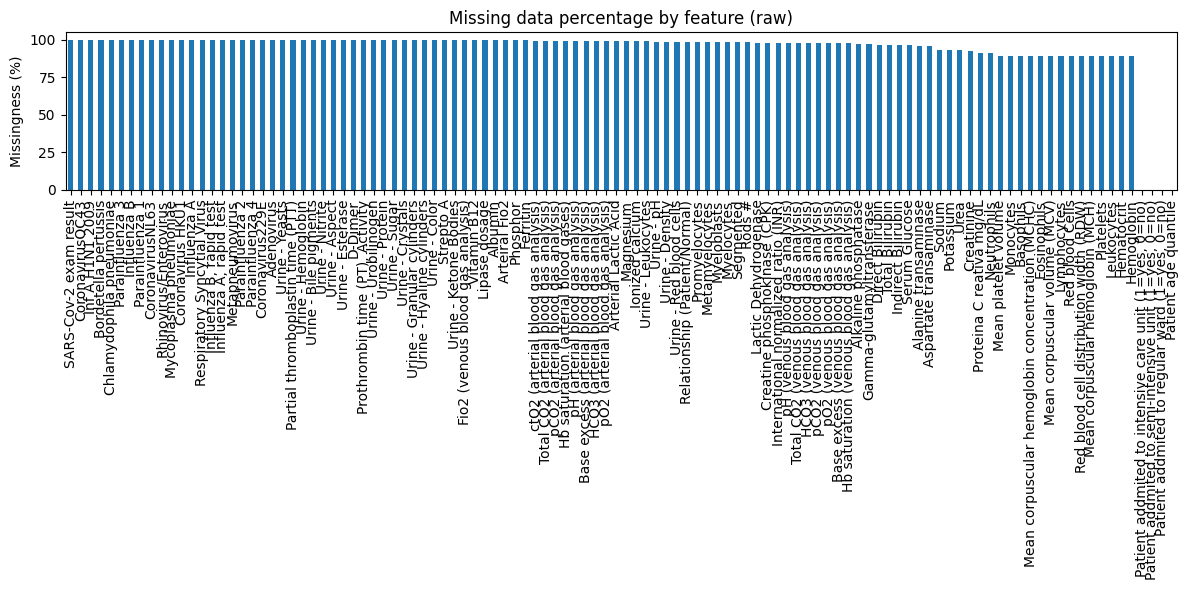

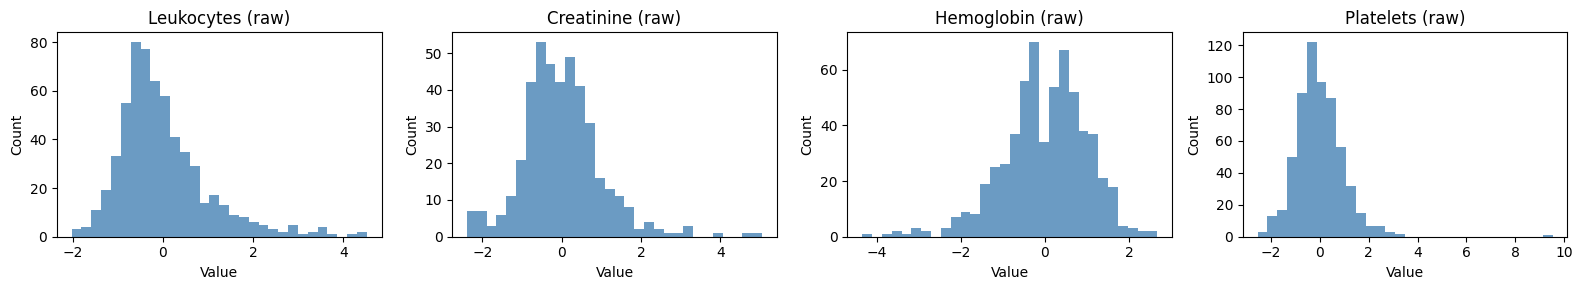

Patients retained: 603
Lab features retained: 37
Data were standardized (z-score) prior to saving.
Shape after cleaning: (603, 41)
Mean of features (should be ~0): 0.000000
Std of features (should be ~1): 1.000000
Saved cleaned data to ..\data\processed\01_cleaned_data.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# Paths
RAW_PATH = Path("../data/raw/dataset.xlsx")
OUT_PATH = Path("../data/processed/01_cleaned_data.csv")
FIG_DIR = Path("../figures")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load
raw = pd.read_excel(RAW_PATH)
# Normalize column names
raw.columns = (raw.columns
               .str.replace(u"\xa0", " ", regex=False)
               .str.replace(r"\s+", " ", regex=True)
               .str.strip())

if "Patient ID" not in raw.columns:
    raise KeyError("'Patient ID' column is required.")

# Convert non-ID to numeric
non_id_cols = [c for c in raw.columns if c != "Patient ID"]
raw[non_id_cols] = raw[non_id_cols].apply(pd.to_numeric, errors="coerce")

# Visualize missingness before filtering/imputation
missing_pct = raw[non_id_cols].isna().mean().sort_values(ascending=False) * 100
plt.figure(figsize=(12, 6))
missing_pct.plot(kind="bar")
plt.ylabel("Missingness (%)")
plt.title("Missing data percentage by feature (raw)")
plt.tight_layout()
plt.show()

# Targets to preserve (not scaled)
target_cols = [
    "SARS-Cov-2 exam result",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
]

# Deduplicate by patient ID
df = raw.drop_duplicates(subset=["Patient ID"]).copy()
all_feature_cols = [c for c in df.columns if c != "Patient ID"]
lab_feature_cols = [c for c in all_feature_cols if c not in target_cols]
existing_targets = [c for c in target_cols if c in df.columns]

# Patient filter: >=10 non-missing labs (exclude target columns)
patient_counts = df[lab_feature_cols].notna().sum(axis=1)
df = df.loc[patient_counts >= 10].copy()

# Feature filter: <80% missing (exclude target columns)
missing_frac = df[lab_feature_cols].isna().mean()
kept_lab_features = missing_frac[missing_frac < 0.80].index.tolist()
final_cols = ["Patient ID"] + kept_lab_features + existing_targets

df = df[final_cols].copy()

# Drop non-clinical identifiers before scaling
id_cols = [c for c in ["Patient ID"] if c in df.columns]
df_no_id = df.drop(columns=id_cols)

# Distribution check (raw, pre-imputation)
rep_candidates = ["Leukocytes", "Creatinine", "Hemoglobin", "Platelets"]
rep_features = [c for c in rep_candidates if c in df_no_id.columns]
if rep_features:
    fig, axes = plt.subplots(1, len(rep_features), figsize=(4 * len(rep_features), 3))
    if len(rep_features) == 1:
        axes = [axes]
    for ax, feat in zip(axes, rep_features):
        ax.hist(df_no_id[feat].dropna(), bins=30, color="steelblue", alpha=0.8)
        ax.set_title(f"{feat} (raw)")
        ax.set_xlabel("Value")
        ax.set_ylabel("Count")
    plt.tight_layout()
    hist_path = FIG_DIR / "raw_feature_histograms.png"
    plt.savefig(hist_path, dpi=200)
    plt.show()

# Impute + scale lab features only
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

imputed = imputer.fit_transform(df_no_id[kept_lab_features])
imputed_df = pd.DataFrame(imputed, columns=kept_lab_features, index=df_no_id.index)

# Drop zero-variance features (std == 0) before scaling
feature_stds = imputed_df.std(ddof=0)
constant_cols = feature_stds[feature_stds == 0].index.tolist()
if constant_cols:
    imputed_df = imputed_df.drop(columns=constant_cols)
    kept_lab_features = [c for c in kept_lab_features if c not in constant_cols]

scaled = scaler.fit_transform(imputed_df)

processed = df_no_id.copy()
if constant_cols:
    processed = processed.drop(columns=constant_cols)

processed[kept_lab_features] = scaled

print(f"Patients retained: {processed.shape[0]}")
print(f"Lab features retained: {len(kept_lab_features)}")
if constant_cols:
    print(f"Dropped constant features: {constant_cols}")
print("Data were standardized (z-score) prior to saving.")

# Verification output
feature_means = processed[kept_lab_features].mean()
feature_stds = processed[kept_lab_features].std(ddof=0)
print(f"Shape after cleaning: {processed.shape}")
print(f"Mean of features (should be ~0): {feature_means.mean():.6f}")
print(f"Std of features (should be ~1): {feature_stds.mean():.6f}")

processed.to_csv(OUT_PATH, index=False)
print(f"Saved cleaned data to {OUT_PATH}")

### Data funnel and rationale (Quality over Quantity)
- **Funnel:** Initial patients → deduplicated → retained with ≤90% missing → final saved. See printed counts above for the exact numbers in this run.
- **Why discard ~90% missing profiles?** Patients with extremely sparse labs lack clinical signal (risk of garbage-in/garbage-out). We keep only those with a rich clinical profile (blood counts + metabolites) to ensure valid downstream inference.
- **Imputation is minimal:** Median imputation applied only after filtering to the retained patients/features; no broad filling of empty records.
- **Standardization:** Features are z-score scaled (StandardScaler) before export to align ranges for PCA/KMeans.
- **Handoff:** Cleaned, scaled dataframe is saved to `../data/processed/01_cleaned_data.csv` for the next notebook.